<a href="https://githubtocolab.com/luismateoh/proyecto-ai4eng/blob/main/01%20-%20test_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab"/></a>



#  Modelo de prueba

**Autor:** [luismateoh](https://github.com/luismateoh)<br>
**Día de creación:** 2022/09/14<br>
**Descripción:** Modelo VGG-16<br>
**Url Dataset:** https://data.mendeley.com/datasets/snkd93bnjr/1

Se sugiere cambiar el tipo de entorno de ejecución a GPU



## Introducción sobre la base de datos

El conjunto de datos contiene un total de 17.092 imágenes de células normales individuales, que se adquirieron utilizando el analizador CellaVision DM96 en el Laboratorio Central del Hospital Clínic de Barcelona. El conjunto de datos está organizado en los siguientes ocho grupos: neutrófilos, eosinófilos, basófilos, linfocitos, monocitos, granulocitos inmaduros (promielocitos, mielocitos y metamielocitos), eritroblastos y plaquetas o trombocitos. El tamaño de las imágenes es de 360 ​​x 363 píxeles, en formato JPG, y fueron anotadas por clínicos patólogos expertos. Las imágenes fueron capturadas de individuos sin infección, enfermedad hematológica u oncológica y libres de cualquier tratamiento farmacológico en el momento de la extracción de sangre. Este conjunto de datos etiquetados de alta calidad se puede usar para entrenar y probar modelos de aprendizaje automático y aprendizaje profundo para reconocer diferentes tipos de células sanguíneas periféricas normales. Hasta donde sabemos, este es el primer conjunto disponible públicamente con un gran número de células sanguíneas periféricas normales, por lo que se espera que sea un conjunto de datos canónico para la evaluación comparativa del modelo.


## Configuración del entorno y dependencias.


Se instalan las dependencias que no estan disponibles en colab, se actualiza matplotlib, y se debe reiniciar la maquina virtual.

In [ ]:
!pip install imagesize
!pip install visualkeras
!pip install matplotlib --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Se importan las dependencias necesarias para ejecutar el notebook.

In [ ]:
import os
import os.path
import imagesize
import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path
from collections import Counter
from ast import literal_eval
import matplotlib.pyplot as plt

import tensorflow as tf

import keras 
from keras import layers
from keras.models import Sequential
from tensorflow.keras import Input
from keras.layers import Rescaling
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import BatchNormalization


import visualkeras

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

## Carga de la base de datos

### Descarga de datos sin procesar

Primero, descarguemos el archivo ZIP de 265M de los datos sin procesar:

Si la descarga falla o el link esta roto, revisar la pagina https://data.mendeley.com/datasets/snkd93bnjr/1 para obtener el enlace actualizado. 

In [ ]:
!curl -O https://prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com/snkd93bnjr-1.zip


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  265M  100  265M    0     0  24.2M      0  0:00:10  0:00:10 --:--:-- 27.6M


In [ ]:
!unzip -q snkd93bnjr-1.zip
!unzip -q PBC_dataset_normal_DIB.zip
!rm -f snkd93bnjr-1.zip PBC_dataset_normal_DIB.zip
!ls


__MACOSX  PBC_dataset_normal_DIB  sample_data


Ahora tenemos una carpeta `PBC_dataset_normal_DIB` que contiene ocho subcarpetas. Cada subcarpeta contiene archivos de imagen para cada categoría


In [ ]:
!ls PBC_dataset_normal_DIB  


basophil    erythroblast  lymphocyte  neutrophil
eosinophil  ig		  monocyte    platelet


### Filtrar imágenes corruptas

Cuando se trabaja con una gran cantidad de datos de imágenes del mundo real, las imágenes corruptas son comunes.
Filtramos las imágenes mal codificadas que no tengan la cadena "JFIF" en su cabecera.


In [ ]:


num_skipped = 0
for folder_name in ("basophil", "erythroblast", "lymphocyte", "neutrophil", "eosinophil", "ig", "monocyte", "platelet"):
    folder_path = os.path.join("PBC_dataset_normal_DIB", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)


Deleted 1 images


## Generación del `Dataset`


Creamos primero un dataset con el 80% de las imagenes para el entrenamiento, y el 20 restante quedarán de validación, que a su vez partiremos para obtener un tercer conjuto de datos de test.

In [ ]:

#Para el modelo que usaremos debe ser de (227,227)
image_size = (224, 224)
batch_size = 32

print("Firt Dataset partition")
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PBC_dataset_normal_DIB",
    validation_split=0.20,
    subset="training",
    seed=2022,
    image_size=image_size,
    batch_size=batch_size,
    label_mode='categorical'
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PBC_dataset_normal_DIB",
    labels='inferred',
    validation_split=0.20,
    subset="validation",
    seed=2022,
    image_size=image_size,
    batch_size=batch_size,
    label_mode='categorical'
)


print("\nSecond Dataset partition")

test_dataset = val_ds.take(5)
val_ds = val_ds.skip(5)

print(f"Train dataset: {len(np.concatenate([i for x, i in train_ds], axis=0))} images.")
print(f"Validation dataset: {len(np.concatenate([i for x, i in val_ds], axis=0))} images.")
print(f"Test dataset: {len(np.concatenate([i for x, i in test_dataset], axis=0))} images.")

Firt Dataset partition
Found 17092 files belonging to 8 classes.
Using 13674 files for training.
Found 17092 files belonging to 8 classes.
Using 3418 files for validation.

Second Dataset partition
Train dataset: 13674 images.
Validation dataset: 3258 images.
Test dataset: 160 images.


## Usando el aumento de datos de imagen

Cuando no tiene un conjunto de datos de imagen grande, es una buena práctica
introduce la diversidad de la muestra mediante la aplicación de transformaciones aleatorias pero realistas a la
imágenes de entrenamiento, como volteo horizontal aleatorio o pequeñas rotaciones aleatorias. Este
ayuda a exponer el modelo a diferentes aspectos de los datos de entrenamiento mientras se disminuye sobreajuste.


In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal_and_vertical"),
        layers.RandomRotation(0.2),
        layers.RandomZoom(.3, .3)

    ]
)

augmented_train_ds = train_ds.map(
  lambda x, y: (data_augmentation(x, training=True), y))

## Configurar el conjunto de datos para el rendimiento

Asegurémonos de usar la captación previa almacenada en búfer para que podamos obtener datos del disco sin tener bloqueos de I/O:


In [ ]:
train_ds = augmented_train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

## Construir un modelo

Construiremos una versión de VGG16


In [ ]:
model = Sequential()
model._name="VGG16"
#Input 
model.add(Input(shape=image_size + (3,)))
#Layer Rescaling
model.add(Rescaling(1.0 / 255))
# Model
model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model.add(BatchNormalization())

model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model.add(BatchNormalization())

model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model.add(BatchNormalization())

model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model.add(BatchNormalization())

model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=8, activation="softmax"))

model.summary()

Model: "VGG16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d_26 (Conv2D)          (None, 224, 224, 64)      1792      
                                                                 
 conv2d_27 (Conv2D)          (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 112, 112, 64)     0         
 g2D)                                                            
                                                                 
 batch_normalization_22 (Bat  (None, 112, 112, 64)     256       
 chNormalization)                                                
                                                                 
 conv2d_28 (Conv2D)          (None, 112, 112, 128)     73856 

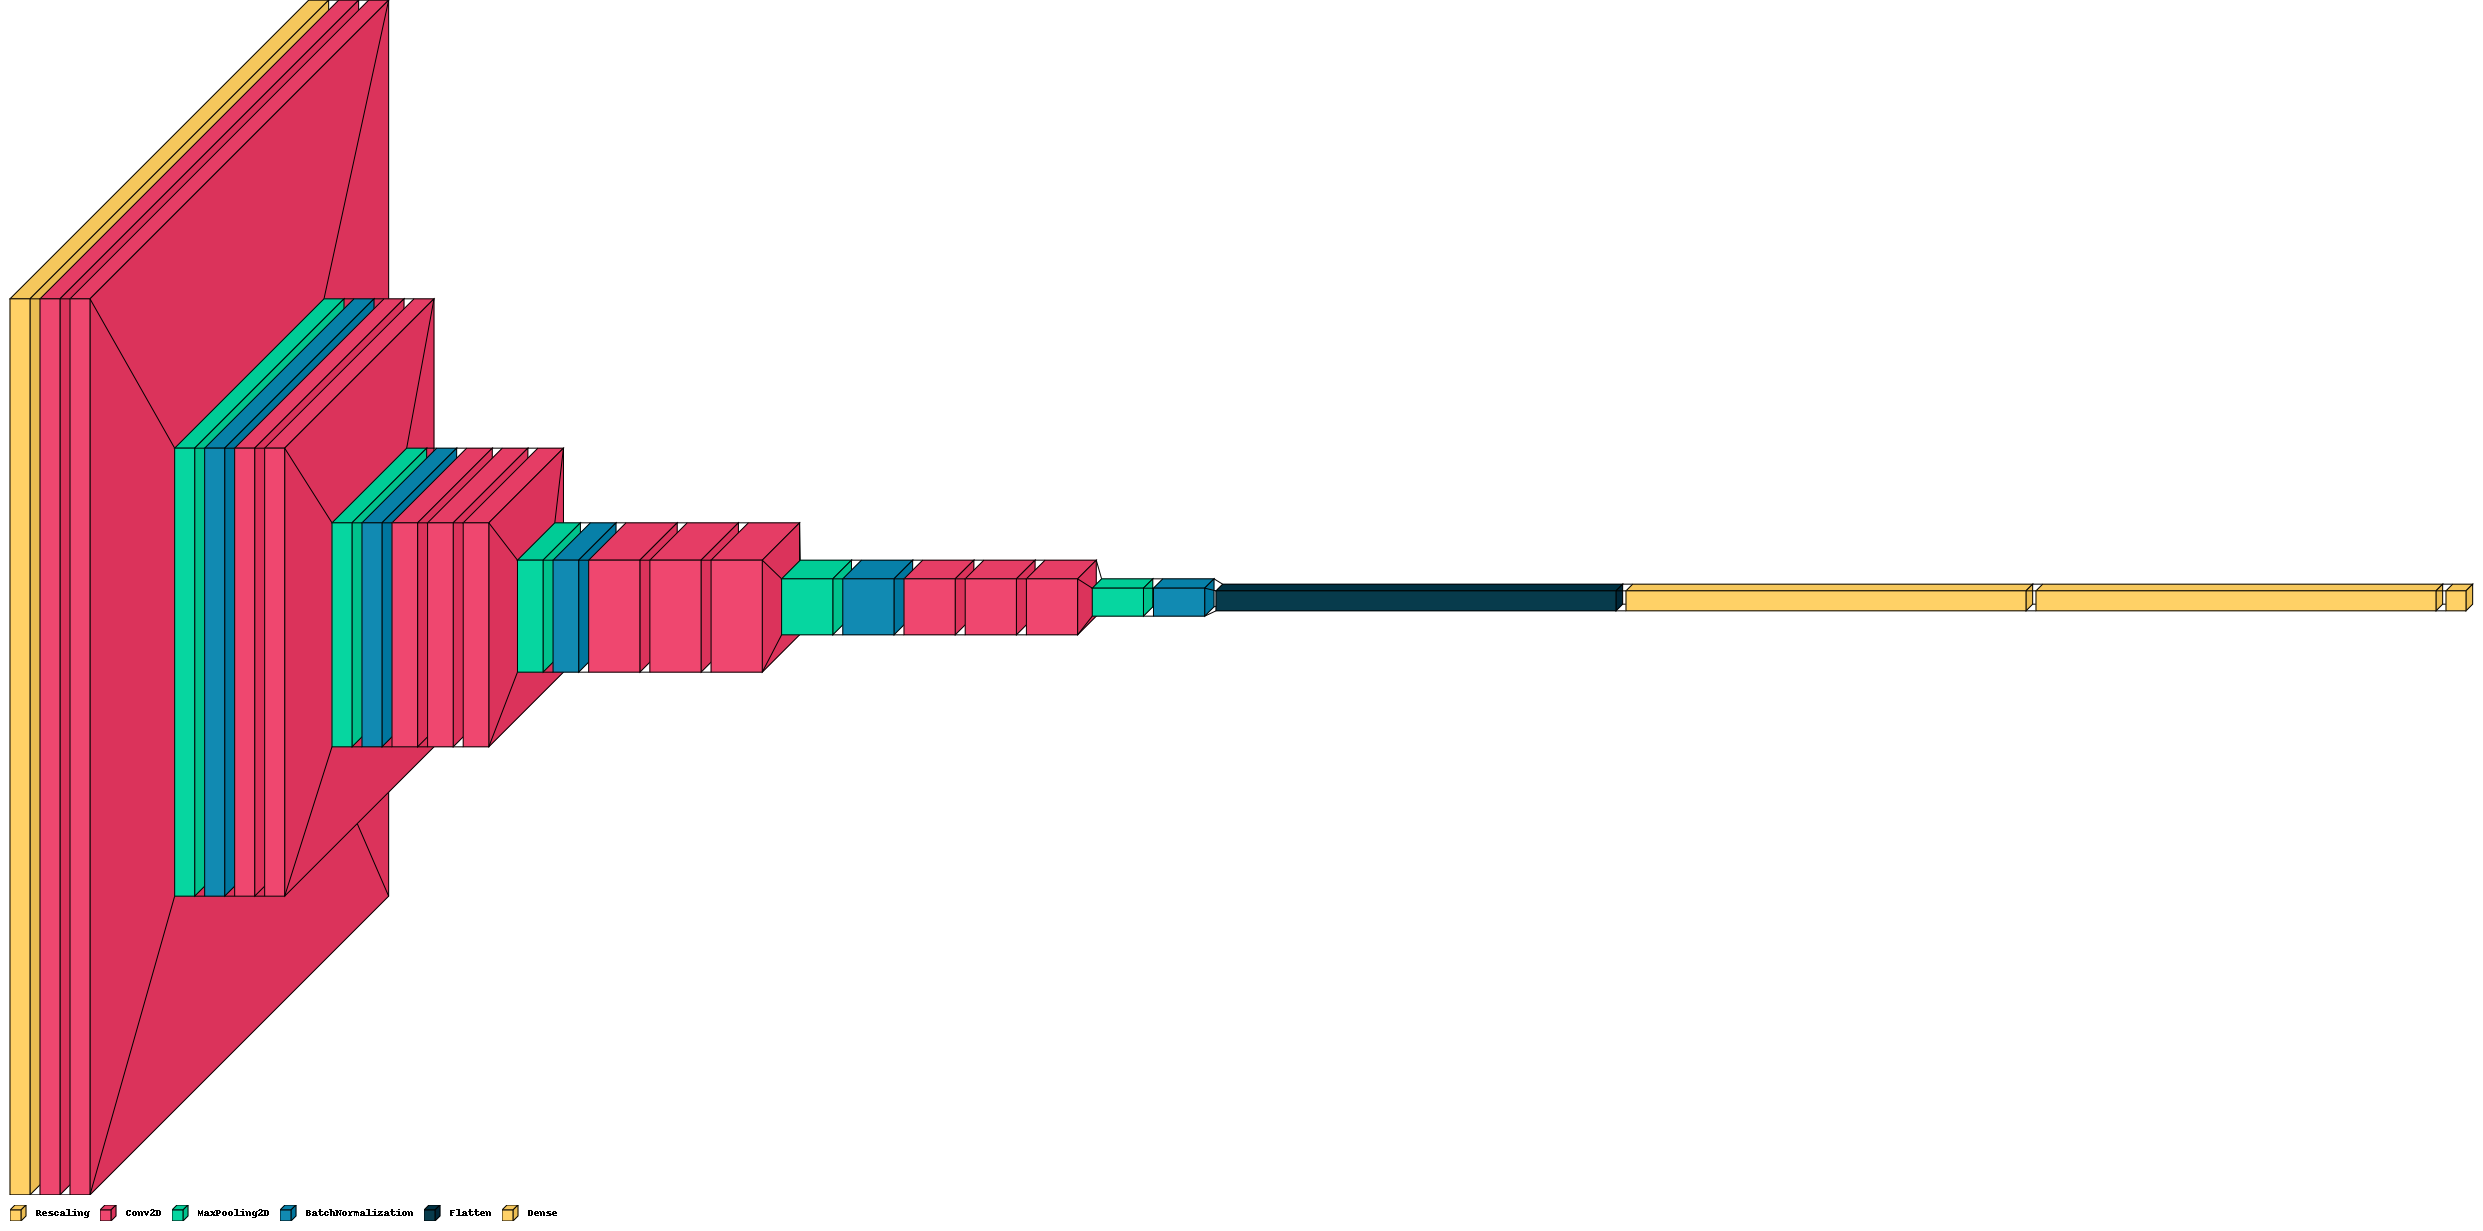

In [ ]:
visualkeras.layered_view(model,legend=True)

## Entrenar el modelo


In [ ]:
epochs = 25

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]

model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics = ['accuracy'])
hist = model.fit(train_ds, 
                 epochs=epochs, 
                 callbacks=callbacks, 
                 validation_data=val_ds)


Epoch 1/25
428/428 [==============================] - 345s 799ms/step - loss: 2.0787 - accuracy: 0.4362 - val_loss: 16.0153 - val_accuracy: 0.1344
Epoch 2/25
428/428 [==============================] - 340s 793ms/step - loss: 1.1145 - accuracy: 0.5866 - val_loss: 6.0977 - val_accuracy: 0.2118
Epoch 3/25
428/428 [==============================] - 339s 791ms/step - loss: 0.7946 - accuracy: 0.7126 - val_loss: 6.1148 - val_accuracy: 0.2462
Epoch 4/25
428/428 [==============================] - 340s 793ms/step - loss: 0.6013 - accuracy: 0.7837 - val_loss: 23.3124 - val_accuracy: 0.1676
Epoch 5/25
428/428 [==============================] - 339s 790ms/step - loss: 0.5215 - accuracy: 0.8129 - val_loss: 1.5278 - val_accuracy: 0.5107
Epoch 6/25
428/428 [==============================] - 340s 793ms/step - loss: 0.4107 - accuracy: 0.8516 - val_loss: 0.5092 - val_accuracy: 0.8382
Epoch 7/25
428/428 [==============================] - 340s 792ms/step - loss: 0.3887 - accuracy: 0.8651 - val_loss: 31.409

## Evaluación y metricas ejecutando inferencia sobre nuevos datos

### Resumen de precisión y función de perdida del modelo

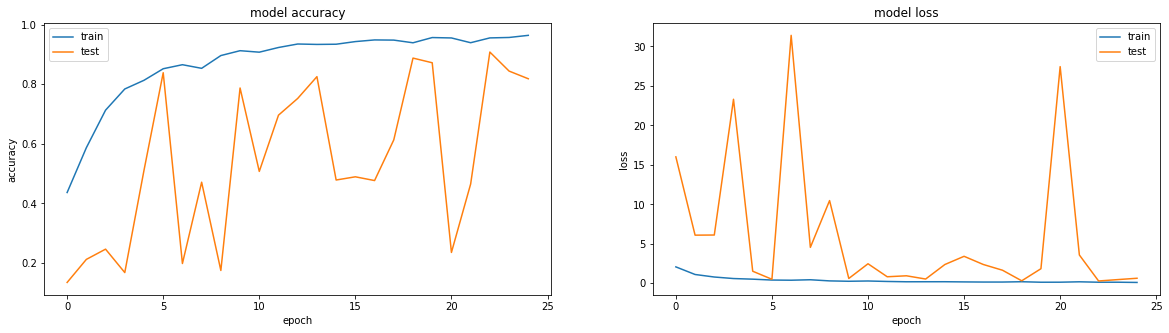

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=False, sharey=False)
fig.set_size_inches(20,5)

ax1.plot(hist.history['accuracy'], label='train')
ax1.plot(hist.history['val_accuracy'],label='test')
ax1.set_title('model accuracy')
ax1.set_ylabel('accuracy')
ax1.set_xlabel('epoch')
ax1.legend(loc='upper left')

ax2.plot(hist.history['loss'], label='train')
ax2.plot(hist.history['val_loss'],label='test')
ax2.set_title('model loss')
ax2.set_ylabel('loss')
ax2.set_xlabel('epoch')
ax2.legend(loc='upper right')


### Clasificación de datos nuevos
Tenga en cuenta que el aumento y la eliminación de datos están inactivos en el momento de la inferencia.

In [ ]:
labels_list = sorted(['erythroblast','eosinophil','monocyte','platelet','lymphocyte',
 'neutrophil','ig','basophil'])

Y_pred = np.array([])
Y_labels =  np.array([])
for x, y in test_dataset:
  Y_pred = np.concatenate([Y_pred, np.argmax(model.predict(x), axis = -1)])
  Y_labels = np.concatenate([Y_labels, np.argmax(y.numpy(), axis=-1)])

### Matriz de confusión

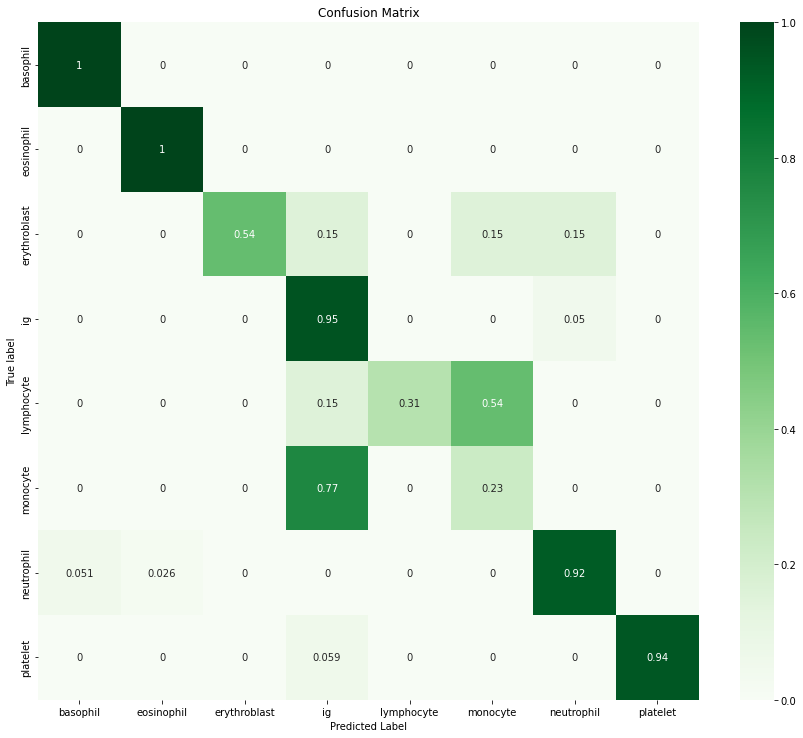

In [ ]:
cf_matrix = confusion_matrix(Y_labels, Y_pred,  normalize="true")
plt.figure(figsize = (12,10))
heatmap = sns.heatmap(cf_matrix, 
            annot=True, 
            xticklabels = labels_list, 
            yticklabels = labels_list,
            cmap=plt.cm.Greens
            )
plt.tight_layout()
heatmap.set_ylabel('True label', fontsize=10)
heatmap.set_xlabel('Predicted Label', fontsize=10)

plt.title('Confusion Matrix')
plt.show()

### Reporte de la clasificación

In [ ]:
print('Classification Report\n')
print(classification_report(Y_labels, Y_pred, target_names=labels_list))

Classification Report

              precision    recall  f1-score   support

    basophil       0.89      1.00      0.94        16
  eosinophil       0.97      1.00      0.98        29
erythroblast       1.00      0.54      0.70        13
          ig       0.56      0.95      0.70        20
  lymphocyte       1.00      0.31      0.47        13
    monocyte       0.25      0.23      0.24        13
  neutrophil       0.92      0.92      0.92        39
    platelet       1.00      0.94      0.97        17

    accuracy                           0.81       160
   macro avg       0.82      0.74      0.74       160
weighted avg       0.85      0.81      0.80       160

